In [1]:
import PIL 
from PIL import Image, ImageFilter
import copy
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.cluster.hierarchy as shc
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [2]:
class Fundus():
    # Constructor
    def __init__(self, initarg=False, **kwargs):
        
        if isinstance(initarg, str):
            self.image = self.image_from_file(initarg)
        
        if isinstance(initarg, np.ndarray):
            self.image = self.image_from_pixels(initarg, **kwargs)
        
        # Getting number of pixels
        self.npixels = np.prod(self.image.size)
        self.size = self.image.size
        self.c = self.image.getbands()
        self.c_size = len(self.c)
        self.palette, self.counts = self.get_palette()
        
    # Constructor from file
    def image_from_file(self, path):
        return Image.open(path)
    
    # Constructor from pixels
    def image_from_pixels(self, pixels, **kwargs):
        arr = np.resize(pixels, (kwargs["w"], kwargs["h"], 3)).astype(np.uint8)
        return Image.fromarray(arr)
    
    # Get numpy array for the image
    def get_array(self):
        return np.asanyarray(self.image)
    
    # Get channel numpy array 
    def get_channels_asarray(self):
        r, g, b = self.image.split()
        return np.asanyarray(r), np.asanyarray(g), np.asanyarray(b)
    
    # Get an scpecific channel as an array
    def get_channel(self, channel):
        return np.asanyarray(self.image.getchannel(channel))
    
    # Transforme the image to a list of pixels
    def get_pixels(self):
        return np.resize(self.get_array(), (self.npixels, self.c_size))
    
    # Ignore, black pixels from list of pixels
    def ignore_black_in_channel(self):
        R,G,B = self.get_pixels().T
        R = np.delete(R, np.where(R == 0))
        G = np.delete(G, np.where(G == 0))
        B = np.delete(B, np.where(B == 0))
        return R, G, B
        
    # Get a unique list of pixels amd their counts (palette)
    def get_palette(self):
        ps = np.sort(self.get_pixels(), axis=0)
        return np.unique(ps, return_counts=True, axis=0)
                         
    # Plot color counts
    def plot_counts(self):
        # Configure subplots
        f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        sns.despine(left=True)
                
        # Plot
        # TODO:  change xlabels to colors
        sns.lineplot(data=self.counts, ax=ax[0])
        sns.lineplot(data=np.sort(self.counts), ax=ax[1])
        
        # Title
        ax[0].set_title("Color sorted")
        ax[1].set_title("Count sorted")
    
    def color_bar(self, colors):
        cmap = mpl.colors.ListedColormap(colors)
        
        # Get hex values for 
        hexcol = np.array([mpl.colors.rgb2hex(x) for x in colors])
        
        # Get figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))
        fig.subplots_adjust(bottom=0.25)
        
        # Calculate bounds
        bounds = range(cmap.N + 1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
        # Plot color bar
        bar = mpl.colorbar.ColorbarBase(ax=ax,
                                       cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       extend="neither",
                                       ticks=None,
                                       ticklocation="top",
                                       drawedges=False,
                                       spacing="uniform",
                                       filled=True,
                                       orientation="horizontal")
        bar.set_ticklabels(hexcol)
        
    
    def plot_palette(self):        
        # Transform 0-255 RGB to 0-1 RGB
        colors = self.palette/255
        
        # plot color bar
        self.color_bar(colors)
    
    
    def plot_cbar(self, nc=5):        
        # Transform 0-255 RGB to 0-1 RGB
        colors = self.palette[np.argsort(self.counts)[::-1][0:nc]]/255
        
        # Plot color bar
        self.color_bar(colors)
    

    # Plots histogram of all color chanels separately and alltogether
    def plot_histogram(self, ignore=True):
        # Set figure
        sns.set(style="white", palette="muted", color_codes=True)
        fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
        sns.despine(left=True)
        
        # Remove black color
        if ignore:
            R, G, B = self.ignore_black_in_channel()
        else:
            R, G, B = self.get_pixels().T
        
        # Plot  00,01 and 10 (separate channels)
        sns.distplot(R, color="r", ax=ax[0, 0])
        sns.distplot(G, color="g", ax=ax[0, 1])
        sns.distplot(B, color="b", ax=ax[1, 0])
               
        # Plot the 3 distributions together
        sns.distplot(R, color="r", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])
        sns.distplot(G, color="g", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])
        sns.distplot(B, color="b", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])

    def plot_lines(self):
        # Plot color distribution of oroginal image
        fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
        sns.despine(left=True)
        
        # Get list of all pixels
        pixels_sorted = np.sort(self.get_pixels(), axis=0)
        ax[0].plot(pixels_sorted)
        ax[0].set_title("All pixels")

        ax[1].plot(self.get_palette()[0])
        ax[1].set_title("Unique pixels")
        
    def get_summary(self):
        df_palette = pd.DataFrame(self.palette, columns=self.c)
        df_summary = pd.DataFrame()
        df_summary["mean"]  = df_palette.mean()
        df_summary["std"]  = df_palette.std()
        df_summary["var"]  = df_palette.var()
        df_summary["max-min"]  = df_palette.max()-df_palette.min()
        
        return df_summary
    
    def replace_pixels(self, colors2replace, replacement = [0, 0, 0]):
        """
        Tales a code of a lost of color codes in RGB 0-255 format.
        And replaces all of those pixels with a given one (default black).
        """
        pixels = self.get_pixels()
        for color in colors2replace:
            pixels[(self.get_pixels() == color).all(axis = 1)] = replacement
        
        return pixels
        

In [3]:
# Read Image, create fundus object
original = Fundus("/mnt/d/eye2gene/data/highscore_pictures/male/male_extra_0.png")

In [46]:
# Get 5 more representative colors in the image
original.image.getpixel((892, 426))

(80, 44, 116)

In [69]:
print(original.get_channels_asarray()[0][426][892])
print(original.get_channels_asarray()[1][426][892])
print(original.get_channels_asarray()[2][426][892])

original.get_array()[426][892]

80
44
116


array([ 80,  44, 116], dtype=uint8)

In [23]:
colors = original.palette[np.argsort(original.counts)[::-1]]#[0:5]]/255
original.color_bar()

TypeError: data type not understood

In [5]:
# Get palette from the image, and sort it by color frequency
#palette = original.palette
#counts = original.counts
palette_sorted = original.palette[np.argsort(original.counts)[::-1]]

In [8]:
# Remove pixels for the most common pixels (usually gray)
print(len(palette_sorted))
arr_new = original.replace_pixels(palette_sorted[:5], [0,0,0])

193


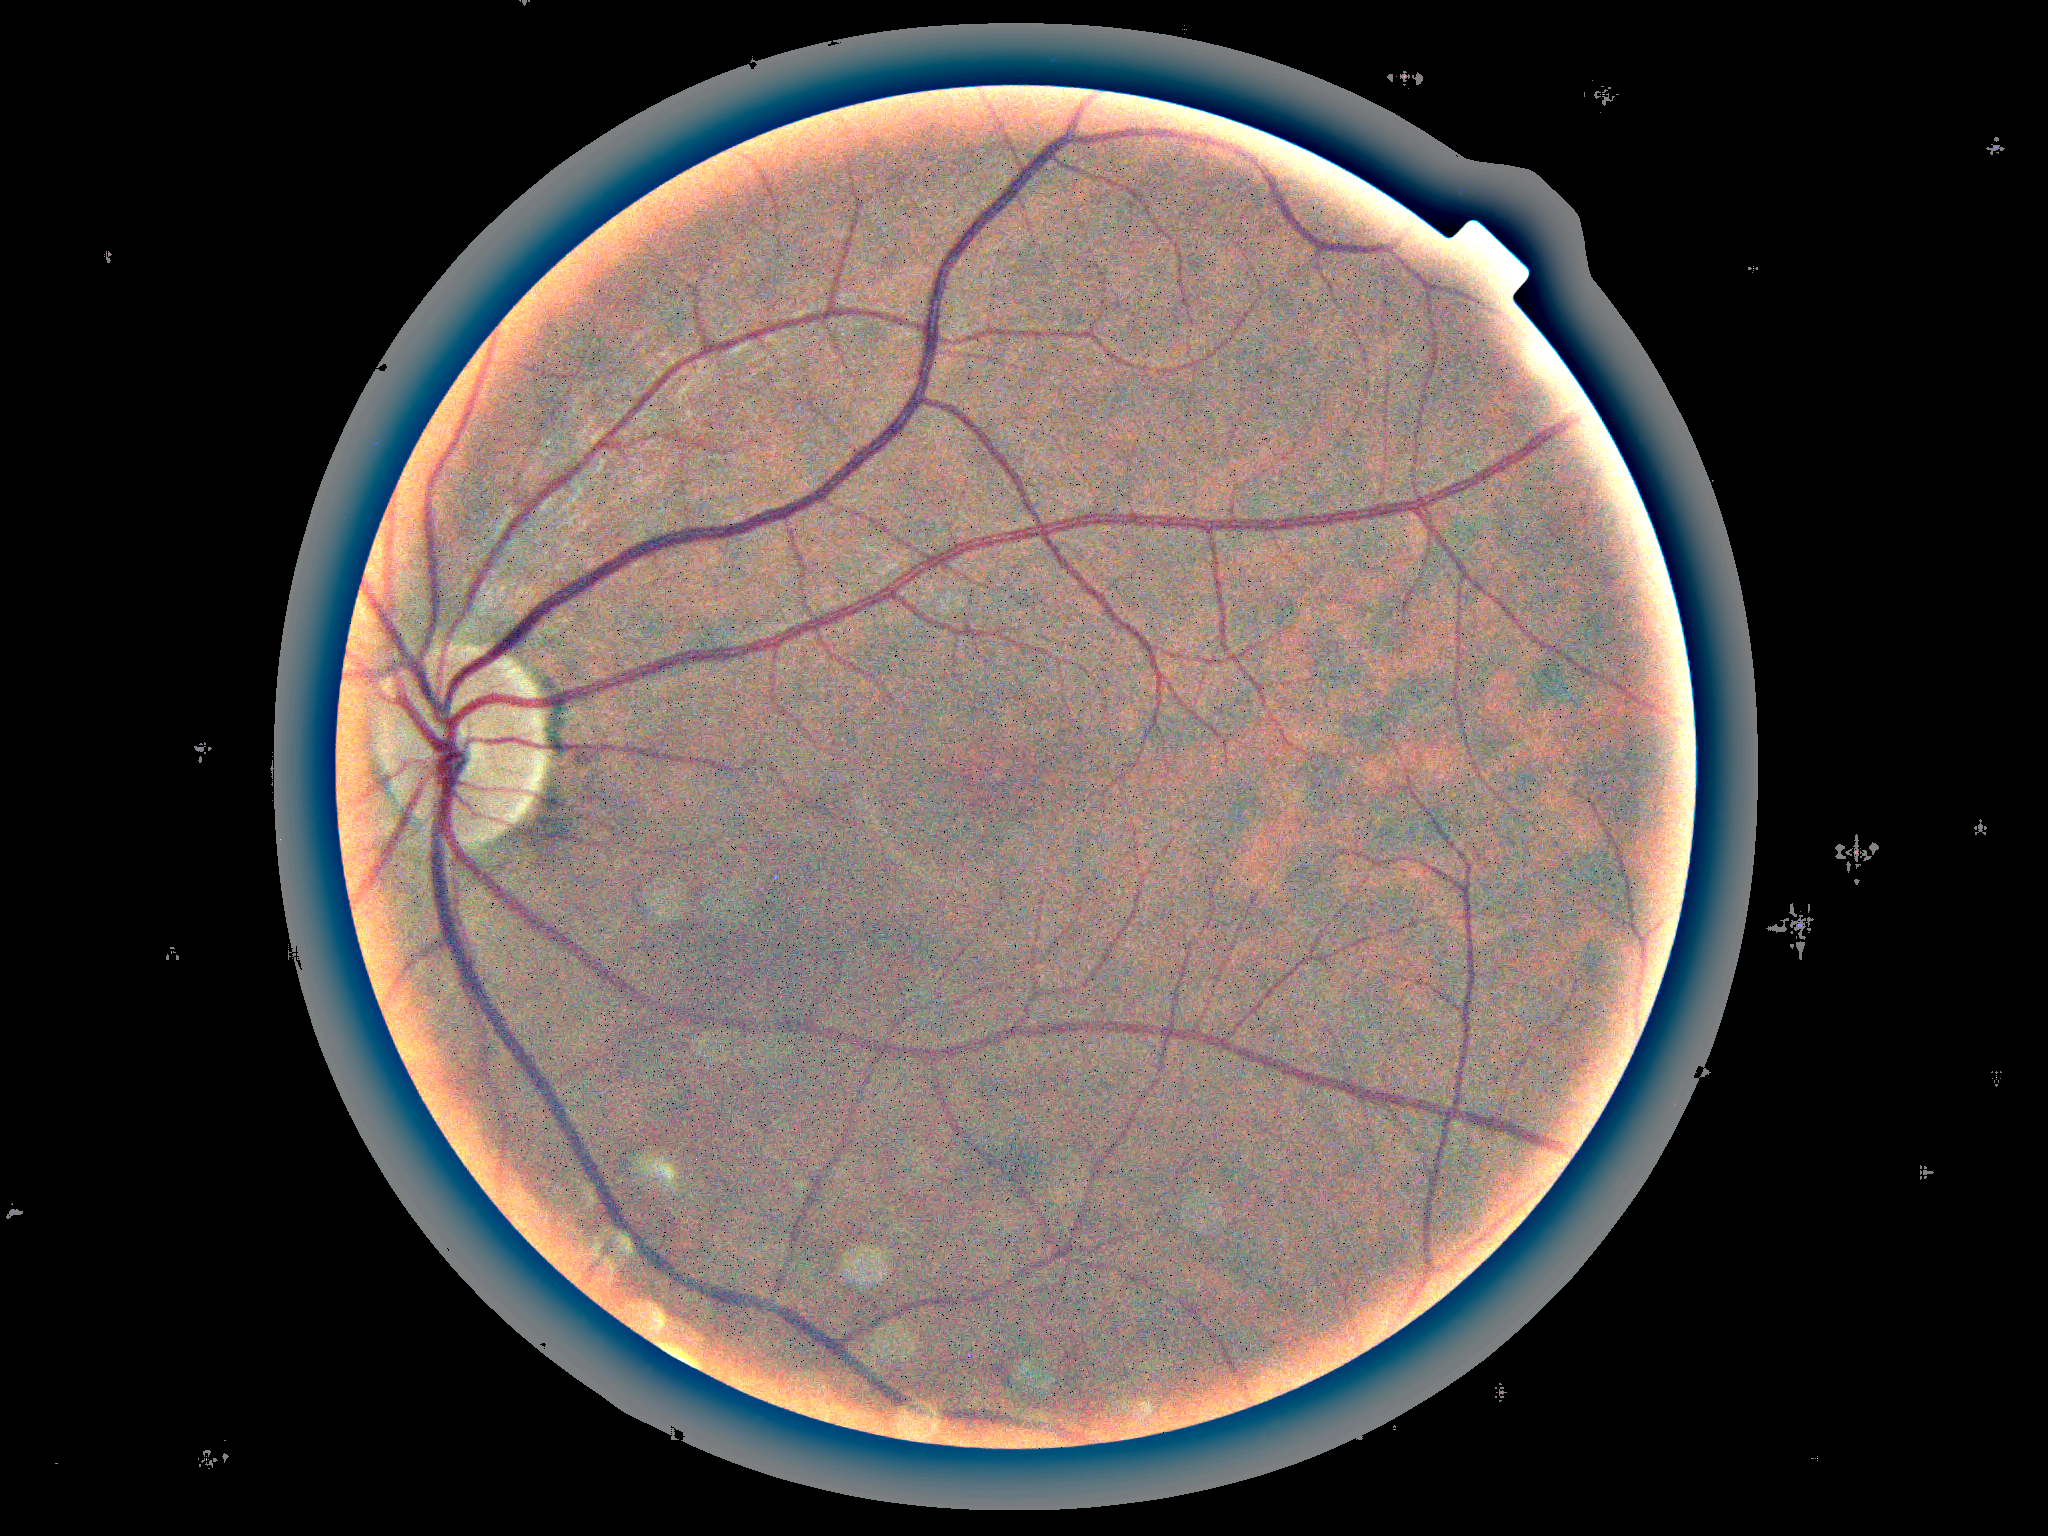

In [9]:
# Generate new figure blackening colors 
new = Fundus(arr_new, w=original.size[1], h=original.size[0])
new.image

# Here we start modifying the image

In [16]:
# Get color palette for the new image
new_palette, new_counts = new.get_palette()
new_palette

array([[  0,   0,   0],
       [  0,   0,   4],
       [  0,   0,   8],
       [  0,   0,  12],
       [  0,   0,  16],
       [  0,   0,  20],
       [  0,   0,  24],
       [  0,   0,  28],
       [  0,   0,  32],
       [  0,   0,  36],
       [  0,   0,  40],
       [  0,   0,  44],
       [  0,   0,  48],
       [  0,   0,  52],
       [  0,   4,  52],
       [  0,   4,  56],
       [  0,   8,  56],
       [  0,   8,  60],
       [  0,  12,  60],
       [  0,  16,  60],
       [  0,  16,  64],
       [  0,  20,  64],
       [  0,  20,  68],
       [  0,  24,  68],
       [  0,  24,  72],
       [  0,  28,  72],
       [  0,  32,  72],
       [  0,  32,  76],
       [  0,  36,  76],
       [  0,  36,  80],
       [  0,  40,  80],
       [  0,  40,  84],
       [  0,  44,  84],
       [  0,  48,  84],
       [  0,  48,  88],
       [  0,  52,  88],
       [  0,  52,  92],
       [  0,  56,  92],
       [  0,  60,  92],
       [  0,  60,  96],
       [  0,  64,  96],
       [  0,  68

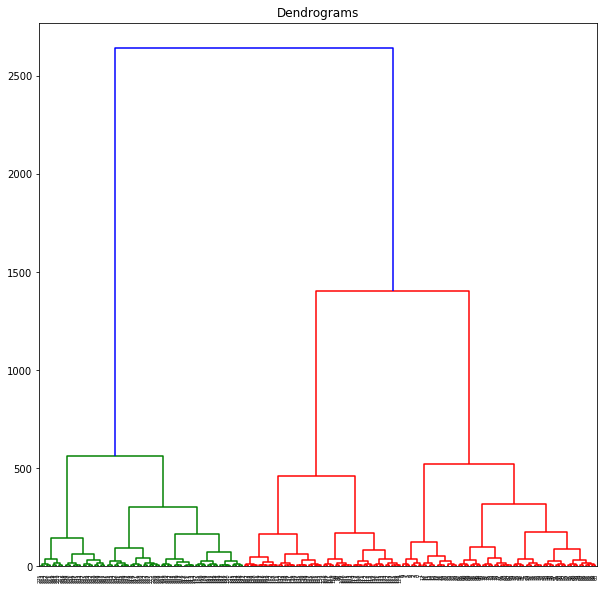

In [128]:
# Get dendogram at pixel level
plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(new_palette, method='ward'))

In [129]:
# Merging 2 closest colors
cluster = AgglomerativeClustering(n_clusters=len(new_palette)//2, affinity='euclidean', linkage='ward')  
clustered = cluster.fit_predict(new_palette)
print("Total number of colors before",len(clustered))
print("Total number of colors after ",len(np.unique(clustered)))

Total number of colors before 276
Total number of colors after  138


In [130]:
# Get RGB values of the colors  to merge
clustered

array([ 88,  86,  43,  43,  43,  35,  35,  35,  61,  61,  47,  47,  47,
       100, 100,  94,  94,  89,  89,  40,  40,  40,  77,  77,  99,  99,
        95,  95,  98,  98,  79,  79,  85,  85,  38,  38,  38,  76,  76,
        76,  73,  73,  73,  37,  37,  37,  48,  48,  48,  29,  29,  29,
        30,  30,  30,  74,  74,  74,  15,  15,  15,  36,  36,  36,  33,
        33,  33,  25,  25,  25,  17,  17,  17,  18,  18,  18,  49,  49,
        49,  41,  41,  41,  20,  20,  20,   8,   8,   8,  26,  26,  26,
        16,  16,  16,  21,  21,  21,  23,  23,  23,  19,  19,  19,  24,
        24,  24,   7,   7,   7,  12,  12,  12,  14,  14,  14, 111,  91,
        22,  22,  22, 110, 127,  11,  11,  11,  10,  10,  10, 109, 107,
         3,   3,   3,  28,  28,  28,   9,   9,   9,  13,  13,  13,   5,
         5,   5,   4,   4,   4,   1,   1,   1, 108, 129,  53, 113,   6,
         6,   6, 106,  80, 105,  69,   2,   2,   2, 104,  52,   0,   0,
         0, 103,  93,  70,  70, 137,  81,  81, 136,  46,  46, 13

In [131]:
np.unique(clustered, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2

In [1]:
pixels = new.get_pixels()

for i in range(len(np.unique(clustered))):
    colors2replace = new_palette[clustered == i]
    replacement = np.mean(new_palette[clustered==i], axis=0, dtype=int)

    for color in colors2replace:
        pixels[(pixels == color).all(axis = 1)] = replacement

NameError: name 'new' is not defined

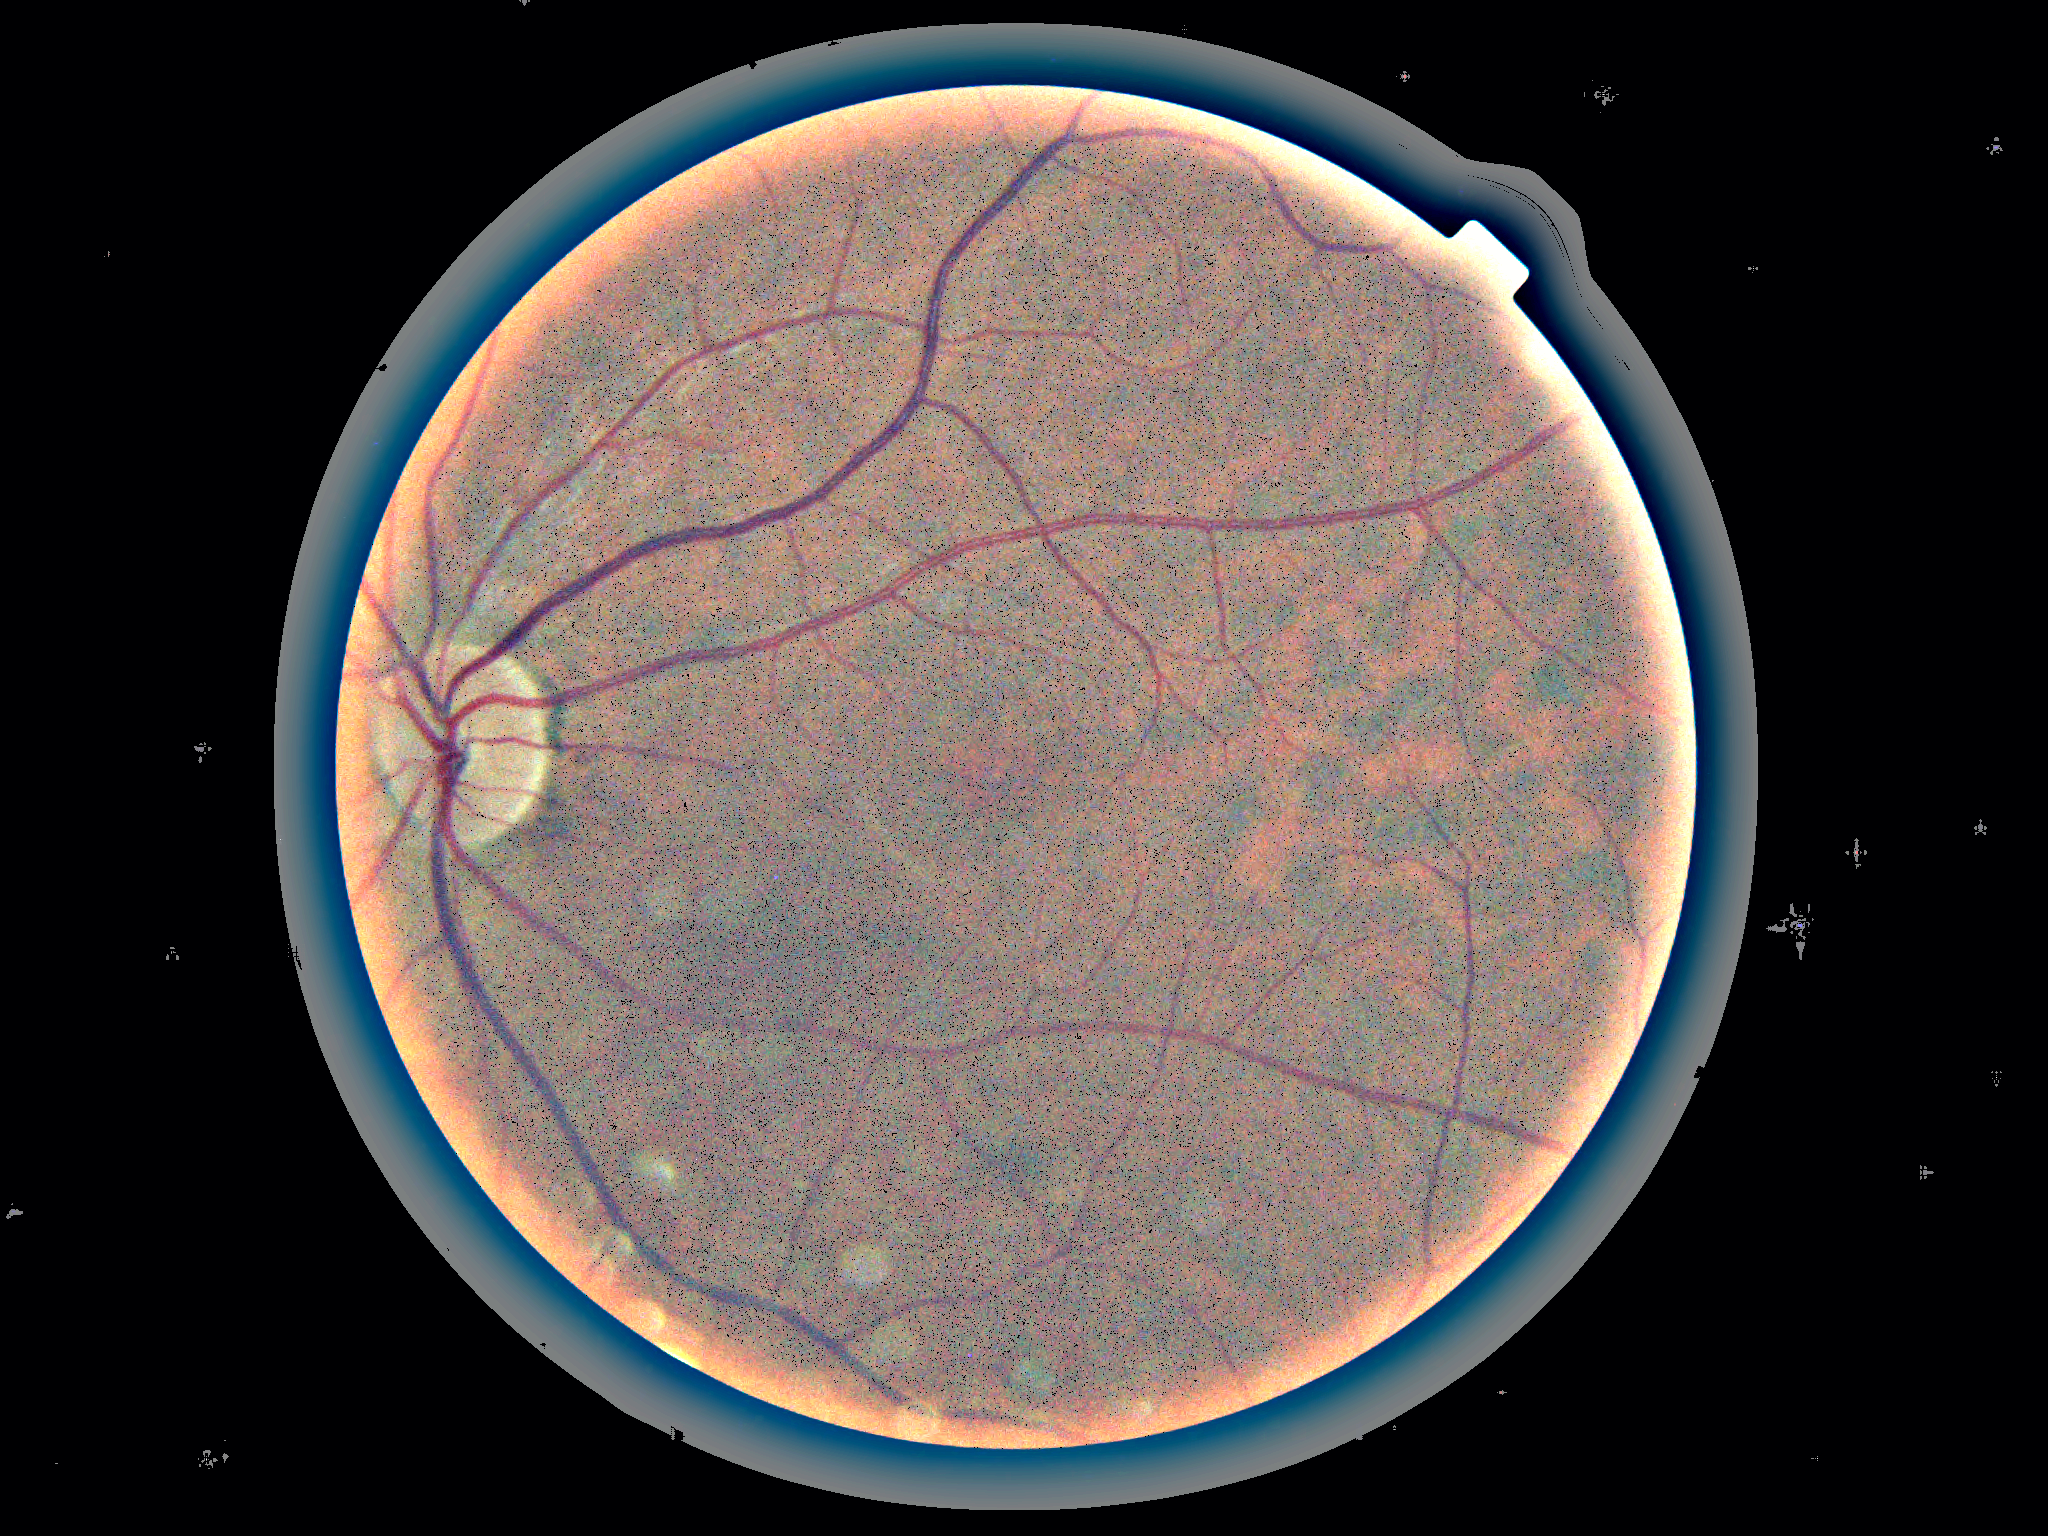

In [133]:
# Generate new figure blackening colors 
new2 = Fundus(pixels, w=original.size[1], h=original.size[0])
new2.image

In [134]:
new2_palette, new_counts = new2.get_palette()

In [135]:
len(new2_palette)

276